p.294

In [1]:
def minkowskiDist(v1, v2, p):
    """v1とv2は長さの等しい数値配列であるとする
       v1とv2の，p次のミンコウスキ距離を返す"""
    dist = 0.0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**p
    return dist**(1.0/p)

p.295

In [2]:
import pylab

In [3]:
class Animal(object):
    def __init__(self, name, features):
        """nameは文字列; featuresは数値のリストとする"""
        self.name = name
        self.features = pylab.array(features)
        
    def getName(self):
        return self.name
    
    def getFeatures(self):
        return self.features
    
    def distance(self, other):
        """otherはAnimalオブジェクトとする
           自分自身とother間のユークリッド距離を返す"""
        return minkowskiDist(self.getFeatures(),
                             other.getFeatures(), 2)

In [4]:
def compareAnimals(animals, precision):
    """animalsはAnimalオブジェクトのリスト, precisionは非負の整数とする
       それぞれのAnimal間のユークリッド距離の表を作る"""
    pylab.figure(dpi=125)
    #行と列のラベルを得る
    columnLabels = []
    for a in animals:
        columnLabels.append(a.getName())
    rowLabels = columnLabels[:]
    tableVals = []
    #Animal間の距離を得る
    #行について
    for a1 in animals:
        row = []
        #列について
        for a2 in animals:
            if a1 == a2:
                row.append('--')
            else:
                distance = a1.distance(a2)
                row.append(str(round(distance, precision)))
        tableVals.append(row)
    #表を作る
    table = pylab.table(rowLabels = rowLabels,
                        colLabels = columnLabels,
                        cellText = tableVals,
                        cellLoc = 'center',
                        loc = 'center',
                        colWidths = [0.2]*len(animals))
    table.scale(1, 2.5)
    pylab.axis('off') #x軸とy軸を表示しない
    pylab.savefig('distances')
    pylab.show()

p.296

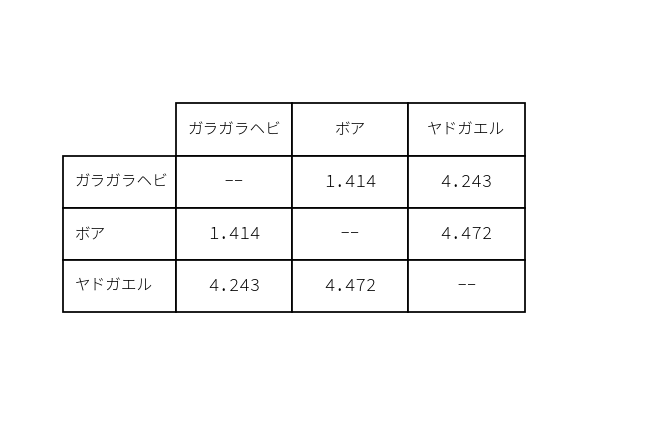

In [5]:
rattlesnake = Animal(u'ガラガラヘビ', [1,1,1,1,0])
boa = Animal(u'ボア', [0,1,0,1,0])
dartFrog = Animal(u'ヤドガエル', [1,0,1,0,4])
animals = [rattlesnake, boa, dartFrog]
compareAnimals(animals, 3)

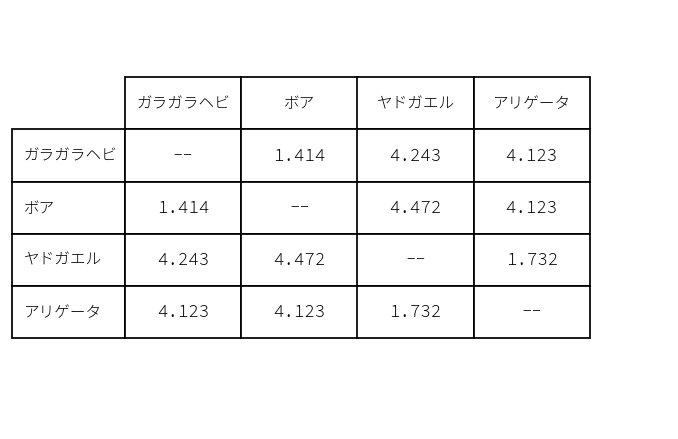

In [6]:
alligator = Animal(u'アリゲータ', [1,1,0,1,4])
animals.append(alligator)
compareAnimals(animals, 3)

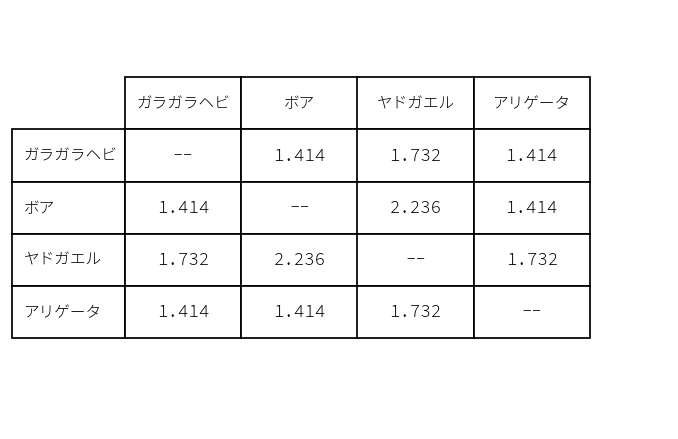

In [7]:
rattlesnake = Animal(u'ガラガラヘビ', [1,1,1,1,0])
boa = Animal(u'ボア', [0,1,0,1,0])
dartFrog = Animal(u'ヤドガエル', [1,0,1,0,1])
alligator = Animal(u'アリゲータ', [1,1,0,1,1])
animals = [rattlesnake, boa, dartFrog, alligator]
compareAnimals(animals, 3)

p.299

In [8]:
class Example(object):
    
    def __init__(self, name, features, label = None):
        #featuresは数の配列である
        self.name = name
        self.features = features
        self.label = label
        
    def dimensionality(self):
        return len(self.features)
    
    def getFeatures(self):
        return self.features[:]
    
    def getLabel(self):
        return self.label
    
    def getName(self):
        return self.name
    
    def distance(self, other):
        return minkowskiDist(self.features, other.getFeatures(), 2)
    
    def __str__(self):
        return self.name +':'+ str(self.features) + ':' \
               +str(self.label)

p.300

In [9]:
class Cluster(object):
    
    def __init__(self, examples, exampleType):
        """examplesはexampleType型のリストとする"""
        self.examples = examples
        self.exampleType = exampleType
        self.centroid = self.computeCentroid()
        
    def update(self, examples):
        """クラスターのexamplesを新しい標本examplesで置き換える
           クラスターの重心が何回変更されたかを返す"""
        oldCentroid = self.centroid
        self.examples = examples
        if len(examples) > 0:
            self.centroid = self.computeCentroid()
            return oldCentroid.distance(self.centroid)
        else:
            return 0.0
        
    def members(self):
        for e in self.examples:
            yield e
        
    def size(self):
        return len(self.examples)
    
    def getCentroid(self):
        return self.centroid
    
    def computeCentroid(self):
        dim = self.examples[0].dimensionality()
        totVals = pylab.array([0.0]*dim)
        for e in self.examples:
            totVals += e.getFeatures()
        centroid = self.exampleType('centroid',
                              totVals/float(len(self.examples)))
        return centroid
    
    def variance(self):
        totDist = 0.0
        for e in self.examples:
            totDist += (e.distance(self.centroid))**2
        return totDist**0.5
    
    def __str__(self):
        names = []
        for e in self.examples:
            names.append(e.getName())
        names.sort()
        result = 'Cluster with centroid '\
                 + str(self.centroid.getFeatures()) + ' contains:\n  '
        for e in names:
            result = result + e + ', '
        return result[:-2]

p.302

In [10]:
def kmeans(examples, exampleType, k, verbose):
    """examplesはexmapleType型の標本リストであり，
       kは正の整数，verboseはブール型とする
       k個のクラスターからなるリストを返す．もしverboseの値が
       Trueならば，k-平均法の各繰り返しの途中結果を出力する      
    """
    #k個の初期中心をランダムに選ぶ
    initialCentroids = random.sample(examples, k)
    
    #それぞれの中心ただ一つからなるクラスターを作成する
    clusters = []
    for e in initialCentroids:
        clusters.append(Cluster([e], exampleType))
        
    #中心が変化しなくなるまで繰り返す
    converged = False
    numIterations = 0
    while not converged:
        numIterations += 1
        #k個の空のリストからなるリストを作成する
        newClusters = []
        for i in range(k):
            newClusters.append([])

        #それぞれのサンプルを最も近い中心へと関連づける
        for e in examples:
            #eに最も近い中心を見つける
            smallestDistance = e.distance(clusters[0].getCentroid())
            index = 0
            for i in range(1, k):
                distance = e.distance(clusters[i].getCentroid())
                if distance < smallestDistance:
                    smallestDistance = distance
                    index = i
            #eを適切なクラスターの標本リストへ加える
            newClusters[index].append(e)
            
        #それぞれのクラスターを更新する; 中心が変化したかどうかをチェック
        converged = True
        for i in range(len(clusters)):
            if clusters[i].update(newClusters[i]) > 0.0:
                converged = False
        if verbose:
            print 'Iteration #' + str(numIterations)
            for c in clusters:
                print c
            print '' #空行を追加する
    return clusters

p.303

In [11]:
def dissimilarity(clusters):
    totDist = 0.0
    for c in clusters:
        totDist += c.variance()
    return totDist

In [12]:
import random

In [13]:
def trykmeans(examples, exampleType, numClusters, numTrials,
              verbose = False):
    """kmeans関数をnumTrials回呼び出しそして，
       最も類似性が小さいクラスタリングを返す"""
    best = kmeans(examples, exampleType, numClusters, verbose)
    minDissimilarity = dissimilarity(best)
    for trial in range(1, numTrials):
        clusters = kmeans(examples, exampleType, numClusters, verbose)
        currDissimilarity = dissimilarity(clusters)
        if currDissimilarity < minDissimilarity:
            best = clusters
            minDissimilarity = currDissimilarity
    return best

p.304

In [14]:
def genDistribution(xMean, xSD, yMean, ySD, n, namePrefix):
    samples = []
    for s in range(n):
        x = random.gauss(xMean, xSD)
        y = random.gauss(yMean, ySD)
        samples.append(Example(namePrefix+str(s), [x, y]))
    return samples

In [15]:
def plotSamples(samples, marker):
    xVals, yVals = [], []
    for s in samples:
        x = s.getFeatures()[0]
        y = s.getFeatures()[1]
        pylab.annotate(s.getName(), xy = (x, y),
                       xytext = (x+0.13, y-0.07),
                       fontsize = 'x-large')
        xVals.append(x)
        yVals.append(y)
    pylab.plot(xVals, yVals, marker)

In [16]:
def contrivedTest(numTrials, k, verbose):
    pylab.figure(dpi=125)
    random.seed(0)
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 10
    d1Samples = genDistribution(xMean, xSD, yMean, ySD, n, '1.')
    plotSamples(d1Samples, 'b^')
    d2Samples = genDistribution(xMean+3, xSD, yMean+1, ySD, n, '2.')
    plotSamples(d2Samples, 'ro')
    clusters = trykmeans(d1Samples + d2Samples, Example, k,
                         numTrials, verbose)
    print 'Final result'
    for c in clusters:
        print '', c
    pylab.show()

Iteration #1
Cluster with centroid [4.57800047 5.35921276] contains:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
Cluster with centroid [3.79646584 2.99635148] contains:
  1.9

Iteration #2
Cluster with centroid [4.80105783 5.73986393] contains:
  1.1, 1.2, 1.4, 1.5, 1.6, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
Cluster with centroid [3.75252146 3.74468698] contains:
  1.0, 1.3, 1.7, 1.8, 1.9

Iteration #3
Cluster with centroid [5.6388835  6.02296994] contains:
  1.6, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
Cluster with centroid [3.19452848 4.28541384] contains:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.7, 1.8, 1.9

Iteration #4
Cluster with centroid [5.93613865 5.96069975] contains:
  2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
Cluster with centroid [3.14170883 4.52143963] contains:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9

Iteration #5
Cluster with centroid [5.93613865 5.96069975] contains:
  2.0, 2.1, 2.2, 2.

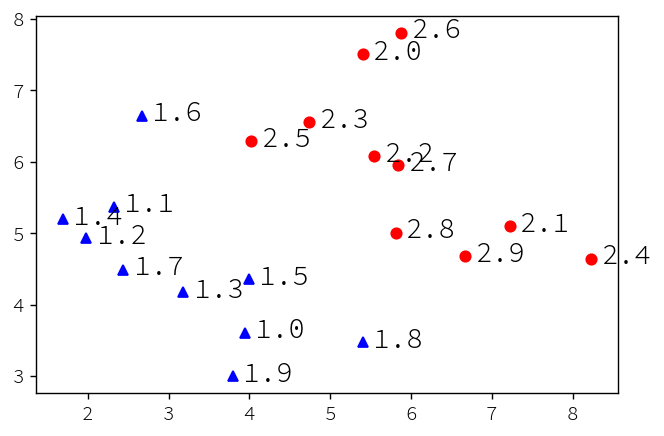

In [17]:
contrivedTest(1, 2, True)

Final result
 Cluster with centroid [5.88777325 5.73417409] contains:
  1.8, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9
 Cluster with centroid [2.89032989 4.63838655] contains:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.9


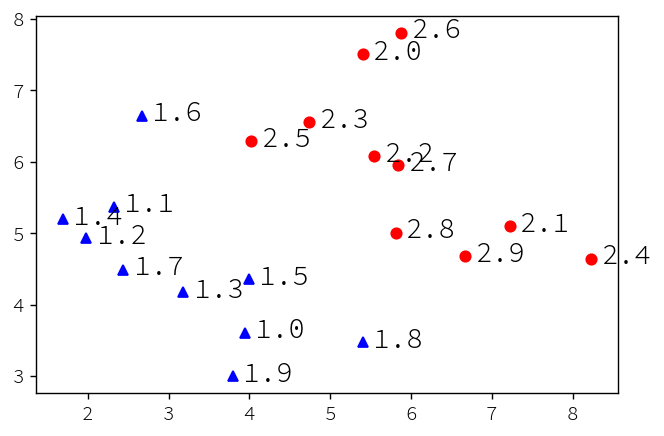

In [18]:
contrivedTest(40, 2, False)

p.306

In [19]:
def contrivedTest2(numTrials, k, verbose):
    pylab.figure(dpi=125)
    random.seed(0)
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 8
    d1Samples = genDistribution(xMean,xSD, yMean, ySD, n, '1.')
    plotSamples(d1Samples, 'b^')
    d2Samples = genDistribution(xMean+3,xSD,yMean, ySD, n, '2.')
    plotSamples(d2Samples, 'ro')
    d3Samples = genDistribution(xMean, xSD, yMean+3, ySD, n, '3.')
    plotSamples(d3Samples, 'gd')
    clusters = trykmeans(d1Samples + d2Samples + d3Samples,
                         Example, k, numTrials, verbose)
    print 'Final result'
    for c in clusters:
        print '', c
    pylab.show()

Final result
 Cluster with centroid [7.66239972 3.55222681] contains:
  2.0, 2.1, 2.3, 2.6
 Cluster with centroid [3.36736761 6.35376823] contains:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 2.2, 2.4, 2.5, 2.7, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7


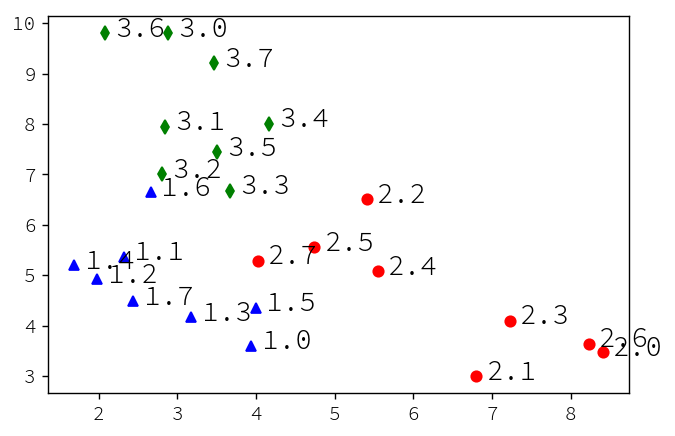

In [20]:
contrivedTest2(40,  2, False)

Final result
 Cluster with centroid [7.66239972 3.55222681] contains:
  2.0, 2.1, 2.3, 2.6
 Cluster with centroid [3.10687385 8.46084886] contains:
  3.0, 3.1, 3.2, 3.4, 3.5, 3.6, 3.7
 Cluster with centroid [3.50763348 5.21918636] contains:
  1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 2.2, 2.4, 2.5, 2.7, 3.3


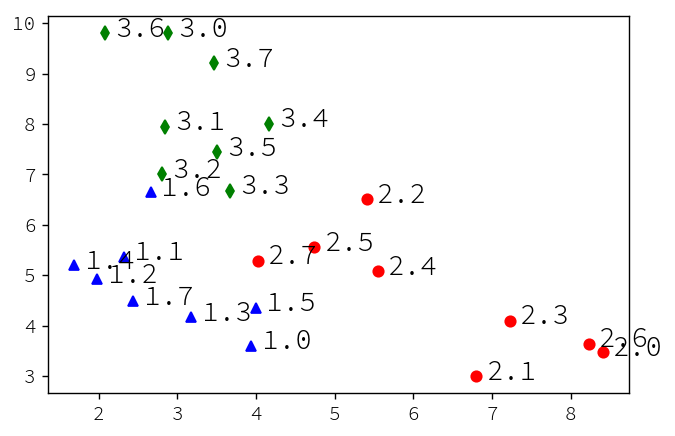

In [21]:
contrivedTest2(40,  3, False)

p.309

In [22]:
import string

In [23]:
def readMammalData(fName):
    dataFile = open(fName, 'r')
    numFeatures = 0
    #ファイルの先頭の処理
    for line in dataFile: #特徴の数を調べる
        if line[0:6] == '#Label': #特徴の終了を示す
            break
        if line[0:5] != '#Name':
            numFeatures += 1
    featureVals = []
    
    #featureVals, speciesNames と labelList の生成
    featureVals, speciesNames, labelList = [], [], []
    for i in range(numFeatures):
        featureVals.append([])
        
    #コメント後の行ごとの処理
    for line in dataFile:
        dataLine = string.split(line[:-1], ',') #改行の除去; その後分割
        speciesNames.append(dataLine[0])
        classLabel = float(dataLine[-1])
        labelList.append(classLabel)
        for i in range(numFeatures):
            featureVals[i].append(float(dataLine[i+1]))
            
    #特徴ベクトルを含むリストを作るためにfeatureValsを使う
    #それぞれのほ乳類について
    featureVectorList = []
    for mammal in range(len(speciesNames)):
        featureVector = []
        for feature in range(numFeatures):
            featureVector.append(featureVals[feature][mammal])
        featureVectorList.append(featureVector)
    return featureVectorList, labelList, speciesNames

p.310

In [24]:
def buildMammalExamples(featureList, labelList, speciesNames):
    examples = []
    for i in range(len(speciesNames)):
        features = pylab.array(featureList[i])
        example = Example(speciesNames[i], features, labelList[i])
        examples.append(example)
    return examples

In [25]:
def testTeeth(numClusters, numTrials):
    features, labels, species = readMammalData('dentalFormulas.txt')
    examples = buildMammalExamples(features, labels, species)
    bestClustering =\
                   trykmeans(examples, Example, numClusters, numTrials)
    for c in bestClustering:
        names = ''
        for p in c.members():
            names += p.getName() + ', '
        print '\n', names[:-2] #後端のコンマとスペースを削除
        herbivores, carnivores, omnivores = 0, 0, 0
        for p in c.members():
            if p.getLabel() == 0:
                herbivores += 1
            elif p.getLabel() == 1:
                carnivores += 1
            else:
                omnivores += 1
        print herbivores, 'herbivores,', carnivores, 'carnivores,',\
              omnivores, 'omnivores'

In [26]:
testTeeth(3, 20)


Badger, Cougar, Dog, Fox, Guinea pig, Jaguar, Kangaroo, Mink, Mole, Mouse, Porcupine, Pig, Rabbit, Raccoon, Rat, Red bat, Skunk, Squirrel, Woodchuck, Wolf
4 herbivores, 9 carnivores, 7 omnivores

Cow, Elk, Moose, Sea lion
3 herbivores, 1 carnivores, 0 omnivores

Bear, Deer, Fur seal, Grey seal, Human, Lion
1 herbivores, 3 carnivores, 2 omnivores


p.311

In [27]:
def scaleFeatures(vals):
    """valsは数列とする"""
    result = pylab.array(vals)
    mean = sum(result)/float(len(result))
    result = result - mean
    sd = stdDev(result)
    result = result/sd
    return result

In [28]:
def variance(X):
    """Xを数のリストとする
       Xの分散を返す"""
    mean = sum(X) / len(X)
    tot = 0.0
    for x in X:
        tot += (x - mean) ** 2
    return tot / len(X)

In [29]:
def stdDev(X):
    """Xを数のリストとする
       Xの標準偏差を返す"""
    return variance(X) ** 0.5

In [30]:
v1, v2 = [], []
for i in range(1000):
    v1.append(random.gauss(100, 5))
    v2.append(random.gauss(50, 10))
v1 = scaleFeatures(v1)
v2 = scaleFeatures(v2)
print 'v1 mean =', round(sum(v1) / len(v1), 4),\
       'v1 standard deviation', round(stdDev(v1), 4)
print 'v2 mean =', round(sum(v2) / len(v2), 4),\
       'v2 standard deviation', round(stdDev(v2), 4)

v1 mean = -0.0 v1 standard deviation 1.0
v2 mean = -0.0 v2 standard deviation 1.0


p.312

In [31]:
def readMammalData(fName, scale):
    """scaleはブール型とする.
       もしTrueならば特徴ベクトルをスケーリングする"""
    dataFile = open(fName, 'r')
    numFeatures = 0
    #ファイルの先頭の処理
    for line in dataFile: #特徴の数を調べる
        if line[0:6] == '#Label': #特徴の終了を示す
            break
        if line[0:5] != '#Name':
            numFeatures += 1
    featureVals = []
    
    #featureVals, speciesNames と labelList の生成
    featureVals, speciesNames, labelList = [], [], []
    for i in range(numFeatures):
        featureVals.append([])
        
    #Continue processing lines in file, starting after comments
    for line in dataFile:
        dataLine = string.split(line[:-1], ',') #改行の除去; その後分割
        speciesNames.append(dataLine[0])
        classLabel = float(dataLine[-1])
        labelList.append(classLabel)
        for i in range(numFeatures):
            featureVals[i].append(float(dataLine[i+1]))

    #特徴ベクトルを含むリストを作るためにfeatureValsを使う
    #それぞれのほ乳類について必要なら特徴ベクトルをスケーリング
    if scale:
        for i in range(numFeatures):
            featureVals[i] = scaleFeatures(featureVals[i])
    featureVectorList = []
    for mammal in range(len(speciesNames)):
        featureVector = []
        for feature in range(numFeatures):
            featureVector.append(featureVals[feature][mammal])
        featureVectorList.append(featureVector)
    return featureVectorList, labelList, speciesNames

In [32]:
def testTeeth(numClusters, numTrials, scale):
    features, classes, species =\
              readMammalData('dentalFormulas.txt', scale)
    examples = buildMammalExamples(features, classes, species)
    #この後のコードは前のバージョンの部分と同じ
    bestClustering =\
                   trykmeans(examples, Example, numClusters, numTrials)
    for c in bestClustering:
        names = ''
        for p in c.members():
            names += p.getName() + ', '
        print '\n', names[:-2]
        herbivores, carnivores, omnivores = 0, 0, 0
        for p in c.members():
            if p.getLabel() == 0:
                herbivores += 1
            elif p.getLabel() == 1:
                carnivores += 1
            else:
                omnivores += 1
        print herbivores, 'herbivores,', carnivores, 'carnivores,',\
              omnivores, 'omnivores'

In [33]:
print 'Cluster without scaling'
testTeeth(3, 20, False)
print '\nCluster with scaling'
testTeeth(3, 20, True)

Cluster without scaling

Badger, Cougar, Dog, Fox, Guinea pig, Human, Jaguar, Kangaroo, Mink, Mole, Mouse, Porcupine, Pig, Rabbit, Raccoon, Rat, Red bat, Skunk, Squirrel, Woodchuck, Wolf
4 herbivores, 9 carnivores, 8 omnivores

Moose
1 herbivores, 0 carnivores, 0 omnivores

Bear, Cow, Deer, Fur seal, Grey seal, Elk, Lion, Sea lion
3 herbivores, 4 carnivores, 1 omnivores

Cluster with scaling

Bear, Dog, Fox, Mole, Pig, Raccoon, Wolf
0 herbivores, 4 carnivores, 3 omnivores

Cow, Deer, Guinea pig, Elk, Human, Kangaroo, Moose, Mouse, Porcupine, Rabbit, Rat, Red bat, Squirrel, Woodchuck
8 herbivores, 1 carnivores, 5 omnivores

Badger, Cougar, Fur seal, Grey seal, Jaguar, Lion, Mink, Sea lion, Skunk
0 herbivores, 8 carnivores, 1 omnivores
